In [18]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
!pip install palmerpenguins
from palmerpenguins import load_penguins


# Download latest version
penguins = load_penguins()
# Training on classifying Gentoo vs Adelie was too easy and lead to perfect models
# So we will compare models using Chinstrap vs Adelie
penguins= penguins[penguins['species']!='Gentoo']
penguins.head()
penguins.dropna(inplace=True)
penguins = penguins[penguins['sex'] != '.']
penguins_encoded = pd.get_dummies(penguins, columns=['species','island','sex'],dtype=int,drop_first=True)
penguins_encoded.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Chinstrap,island_Dream,island_Torgersen,sex_male
0,39.1,18.7,181.0,3750.0,2007,0,0,1,1
1,39.5,17.4,186.0,3800.0,2007,0,0,1,0
2,40.3,18.0,195.0,3250.0,2007,0,0,1,0
4,36.7,19.3,193.0,3450.0,2007,0,0,1,0
5,39.3,20.6,190.0,3650.0,2007,0,0,1,1


species_Chinstrap
0    146
1     68
Name: count, dtype: int64


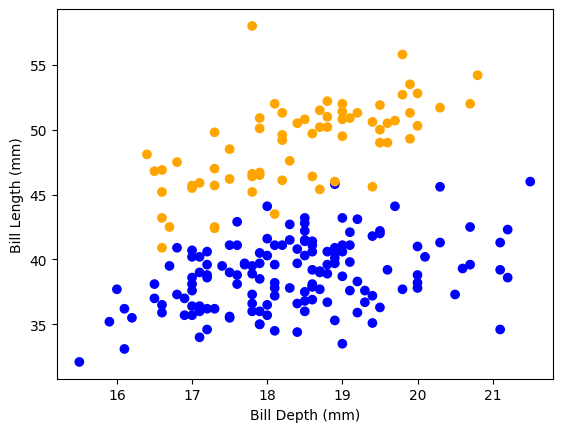

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,ConfusionMatrixDisplay

X = penguins_encoded.drop('species_Chinstrap', axis=1)
#1 for Chinstrap (true), 0 for adelie
y = penguins_encoded['species_Chinstrap']
print(y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
plt.scatter(penguins_encoded['bill_depth_mm'],penguins_encoded['bill_length_mm'],c=(penguins_encoded['species_Chinstrap'].map({0:'blue',1:'orange'})))
plt.xlabel('Bill Depth (mm)')
plt.ylabel('Bill Length (mm)')
plt.show()
#Can split the two groups nearly over only two features

The dataset is imbalanced (roughly twice as many in the adelie class as there are in chinstrap) and small. The size may not be helpful for naive bayes as it requires a lot of data.

# Naive Bayes
Naive Bayes was almost 80% accurate, however classifies some adelie penguins as Chinstrap. We can see that naive bayes splits the data in half, roughly 50% going to each class which could be due to random chance rather than true accuracy.

species_Chinstrap
0    46
1    19
Name: count, dtype: int64
Accuracy: 0.7846153846153846
Confusion Matrix:
[[32 14]
 [ 0 19]]
F1 Score: 0.7307692307692307


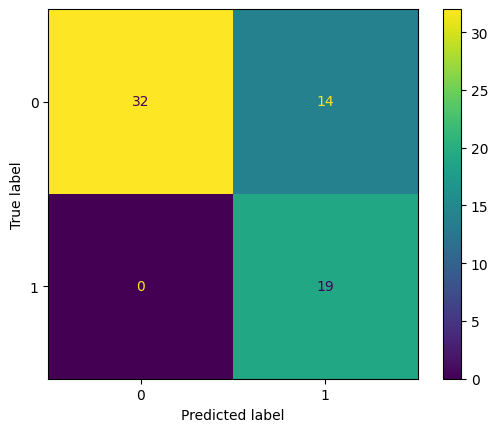

In [3]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
binary_f1 = f1_score(y_test, y_pred, average='binary')

print(y_test.value_counts())
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f"F1 Score: {binary_f1}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=nb.classes_)
disp.plot()


# Logistic Regression
This model performed "perfectly". While naive bayes had good accuracy, logistic regression excelled at classification as expected.

Accuracy: 1.0
Confusion Matrix:
[[46  0]
 [ 0 19]]
F1 Score: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


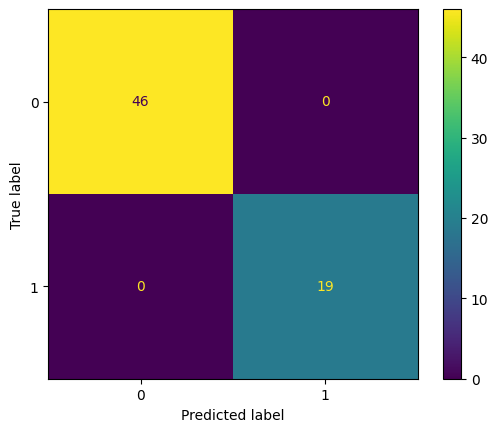

In [4]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
binary_f1 = f1_score(y_test, y_pred_lr, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f"F1 Score: {binary_f1}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=lr.classes_)
disp.plot()

AUC for Logistic Regression: 1.0
AUC for Naive Bayes: 0.9965675057208239


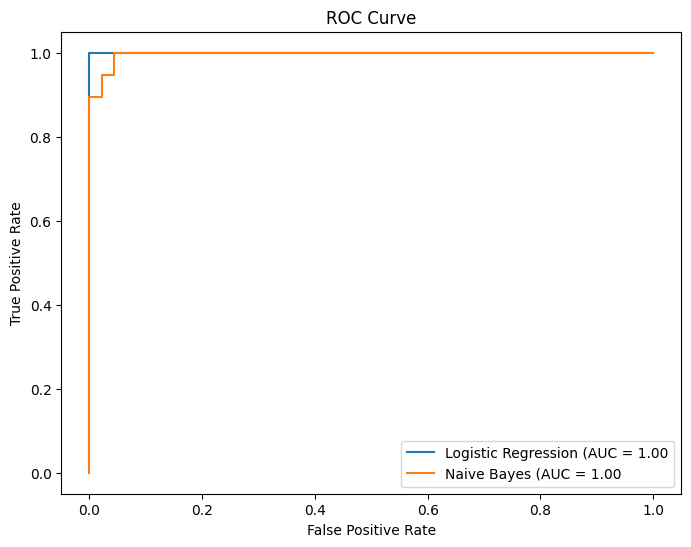

In [5]:
from sklearn.metrics import roc_auc_score,roc_curve

y_lr_proba = lr.predict_proba(X_test)
y_nb_proba = nb.predict_proba(X_test)

auc_lr = roc_auc_score(y_test, y_lr_proba[:,1])
auc_nb = roc_auc_score(y_test, y_nb_proba[:,1])

print(f'AUC for Logistic Regression: {auc_lr}')
print(f'AUC for Naive Bayes: {auc_nb}')

fpr, tpr, thresholds = roc_curve(y_test, y_lr_proba[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_nb_proba[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_lr:.2f}')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#ROC curves are virtually the same

However, NB predicted some of the Adelies (negatives) to be Chinstraps (positive) so it is not a perfect 1.00 even though it rounds to be. This is also due to the small dataset so the curves are not very realistic.

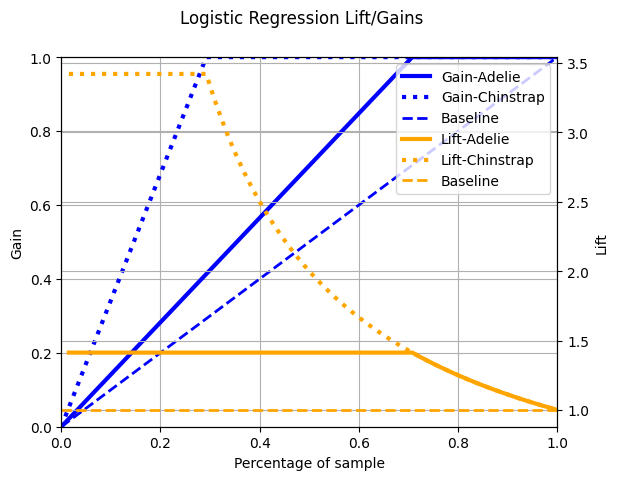

In [20]:
import numpy as np
from numpy import interp
!pip install scipy==1.11.4
import scikitplot as skplt

fig, axes = plt.subplots()
fig.suptitle('Logistic Regression Lift/Gains')

skplt.metrics.plot_cumulative_gain(y_test, y_lr_proba, ax=axes)
gain_lines = axes.get_lines()
gain_lines[0].set(color='blue', label='Gain-Adelie')
gain_lines[1].set(color='blue', linestyle=':', label='Gain-Chinstrap')
gain_lines[2].set(color='blue', label='Baseline')
axes.set_title(None)
ax2 = axes.twinx()
skplt.metrics.plot_lift_curve(y_test, y_lr_proba, ax=ax2)
lift_lines = ax2.get_lines()
lift_lines[0].set(color='orange', label='Lift-Adelie')
lift_lines[1].set(color='orange', linestyle=':', label='Lift-Chinstrap')
lift_lines[2].set(color='orange', label='Baseline')
ax2.set_title(None)
lines = gain_lines + lift_lines
lables = [line.get_label() for line in lines]
axes.get_legend().remove()
ax2.get_legend().remove()
ax2.legend(lines,lables,loc='best')
plt.show()

The gain shows that the model can predict chinstraps early, but are less sure when predicting adelie penguins. The lift also shows it is significantly better at guessing chinstraps, while identifying adelie penguins is nearly random with a lift of 1.5.

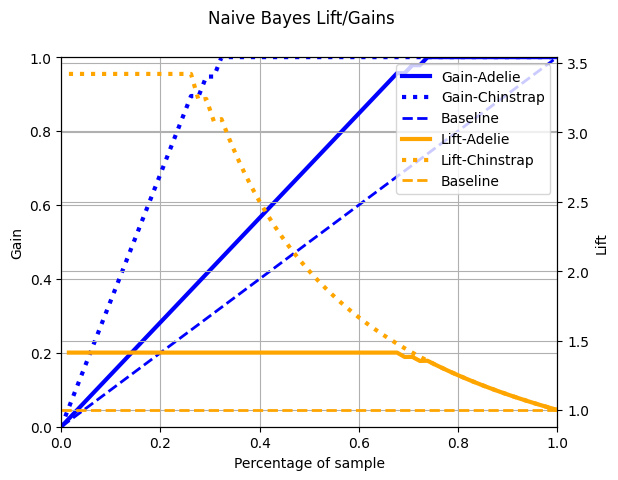

In [22]:

fig, axes = plt.subplots()
fig.suptitle('Naive Bayes Lift/Gains')

skplt.metrics.plot_cumulative_gain(y_test, y_nb_proba, ax=axes)
gain_lines = axes.get_lines()
gain_lines[0].set(color='blue', label='Gain-Adelie')
gain_lines[1].set(color='blue', linestyle=':', label='Gain-Chinstrap')
gain_lines[2].set(color='blue', label='Baseline')
axes.set_title(None)
ax2 = axes.twinx()
skplt.metrics.plot_lift_curve(y_test, y_nb_proba, ax=ax2)
lift_lines = ax2.get_lines()
lift_lines[0].set(color='orange', label='Lift-Adelie')
lift_lines[1].set(color='orange', linestyle=':', label='Lift-Chinstrap')
lift_lines[2].set(color='orange', label='Baseline')
ax2.set_title(None)
lines = gain_lines + lift_lines
lables = [line.get_label() for line in lines]
axes.get_legend().remove()
ax2.get_legend().remove()
ax2.legend(lines,lables,loc='best')
plt.show()

The naive bayes shows a similar pattern as the logistic regression, however there is a bit of a difference at the elbow of the curves due to its lower predictive accuracy.

#Summary

Based on these results, both models are relatively accurate however logistic regression is better at classifying penguins. They are both particularly good at identifying chinstrap penguins over adleie penguins. Logistic regression had the higher (100%) accuracy, higher AUC (1.0) and slightly better lift/gain chart.